In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
dataset = pd.read_csv("dublinbikes_20200101_20200401.csv")
df = dataset

In [3]:
df1 = df.copy()
df1['STATUS'] = df1['STATUS'].astype('category')
df1['LAST UPDATED'] = pd.to_datetime(df1['LAST UPDATED'])
df1['TIME'] = pd.to_datetime(df1['TIME'])
df1['formatted_time'] = df1['TIME'].dt.floor('h')

df1['day_of_week'] = df1['formatted_time'].dt.strftime('%A')
df1['day_of_month'] = df1['formatted_time'].dt.strftime('%d').astype(np.int64)
df1['hour'] = df1['formatted_time'].dt.strftime('%H').astype(np.int64)
df1['month'] = df1['formatted_time'].dt.strftime('%m').astype(np.int64)
df1['week'] = df1['formatted_time'].dt.strftime('%w').astype(np.int64)
numeric_columns = df1.select_dtypes(['int64']).columns
print(df1[numeric_columns].describe().T)
print(df1.select_dtypes(['category']).describe().T)
print(df1.dtypes)

                           count       mean        std   min   25%   50%  \
STATION ID             2228278.0  60.196628  33.598271   2.0  31.0  61.0   
BIKE STANDS            2228278.0  32.184342   7.666891  16.0  29.0  30.0   
AVAILABLE BIKE STANDS  2228278.0  20.456110  11.140868   0.0  12.0  20.0   
AVAILABLE BIKES        2228278.0  11.644086   9.980968   0.0   3.0  10.0   
day_of_month           2228278.0  15.902037   9.262035   1.0   8.0  16.0   
hour                   2228278.0  11.556068   6.876381   0.0   6.0  12.0   
month                  2228278.0   2.317890   0.729879   1.0   2.0   2.0   
week                   2228278.0   2.991054   1.976522   0.0   1.0   3.0   

                        75%    max  
STATION ID             90.0  117.0  
BIKE STANDS            40.0   40.0  
AVAILABLE BIKE STANDS  29.0   41.0  
AVAILABLE BIKES        18.0   40.0  
day_of_month           24.0   31.0  
hour                   17.0   23.0  
month                   3.0    4.0  
week               

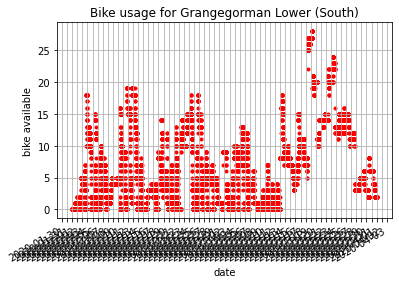

In [4]:
ts = pd.to_datetime('2020/02/01')
te = pd.to_datetime('2020/04/01')
mask = (df1['TIME'] >= ts) & (df1['TIME'] <= te)
pd.options.mode.chained_assignment = None
#df['TIME'].max() - df['TIME'].min()
#suburb_point = "Merrion Square South"
suburb_point = "Grangegorman Lower (South)"
suburb_df = df1.loc[mask]
suburb_df = suburb_df[suburb_df['ADDRESS'] == suburb_point]
suburb_dataset = suburb_df[['TIME', 'AVAILABLE BIKES']]
#fig, ax = plt.subplots()

suburb_dataset['date'] = suburb_dataset['TIME'].dt.floor('T')
suburb_dataset = suburb_dataset.reset_index()
suburb_dataset.drop('TIME',axis=1, inplace=True)
time = suburb_dataset['date']
bikes = suburb_dataset['AVAILABLE BIKES']
#plot 2 week data for Merrion Square South region
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.scatter(time,bikes, color="red", marker=".", label='bike count')
ax.set_xlabel("date")
ax.set_ylabel("bike available")
fig.autofmt_xdate()
ax.grid(True)
ax.set_title(f'Bike usage for {suburb_point}')
plt.show()

In [23]:
# GET LAG VALUE (4)

from sklearn.metrics import r2_score
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]

q=2
lag_range = [1,2,3,4]
stride=1
Ci = 50
scores = []
errors = []
for lag in lag_range:
    w=math.floor(7*24*60*60/dt)
    length = bikes.size - w - lag * w - q
    print("intial set : ", bikes.size, w, lag, q, length)
    XX=bikes[q:q+length:stride]
    #week
    for i in range(1,lag):
        X=bikes[i*w+q:i*w+q+length:stride]
        XX=np.column_stack((XX,X))
    d=math.floor(24*60*60/dt)
    #days
    for i in range(0,lag):
        X=bikes[i*d+q:i*d+q+length:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=bikes[i:i+length:stride]
        XX=np.column_stack((XX,X))

    yy=bikes[lag*w+w+q:lag*w+w+q+length:stride] 
    tt=time[lag*w+w+q:lag*w+w+q+length:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)

    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    a = 1/(2*Ci)
    print("lag value - ", lag)
    model = Lasso(alpha= a).fit(XX[train], yy[train])
    y_pred = model.predict(XX)
    score = model.score(XX[test], yy[test])
    from sklearn.model_selection import cross_val_score
    mse = mean_squared_error(yy,y_pred)
    errors.append(mse)
    r2 = r2_score(yy,y_pred)
    scores.append(r2)
    print("SCORE: {0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
    .format(score,  mse,np.sqrt(mse)))
    print(f'r2_score - {r2}')

plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig=plt.figure()
#ax1=fig.add_subplot(111)
ax1.plot(lag_range,scores)
ax1.set_xlabel('Alpha (lag range)')
ax1.set_ylabel('Beta (Score)')
ax1.set_title('Model Score vs Lag Value')
ax1.axis('tight')

# fig=plt.figure()
# ax2=fig.add_subplot(111)

ax2 = plt.gca()
ax2.ticklabel_format(useOffset=False)
errors = [round(num, 5) for num in errors]

ax2.plot(lag_range, errors)
ax2.set_xlabel("lag")
ax2.set_ylabel("error")
ax2.set_title("Error vs Lag")
ax2.axis("tight")
fig.show()
# ax2.set_yticklabels(errors)
print(scores)
print(errors)
print(lag_range)

intial set :  17127 2016 1 2 13093
lag value -  1
SCORE: 0.377, MSE:54.42, RMSE:7.38
r2_score - 0.37585320160868774
intial set :  17127 2016 2 2 11077
lag value -  2
SCORE: 0.349, MSE:54.77, RMSE:7.40
r2_score - 0.3508680777027573
intial set :  17127 2016 3 2 9061
lag value -  3
SCORE: 0.345, MSE:50.85, RMSE:7.13
r2_score - 0.3551277623872381
intial set :  17127 2016 4 2 7045
lag value -  4
SCORE: 0.184, MSE:45.45, RMSE:6.74
r2_score - 0.20774499664481016
[0.37585320160868774, 0.3508680777027573, 0.3551277623872381, 0.20774499664481016]
[54.41641, 54.77163, 50.84549, 45.45444]
[1, 2, 3, 4]


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1906.2585007099551, tolerance: 74.52018745062634
  model = cd_fast.enet_coordinate_descent(
C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73896.35081857556, tolerance: 56.9177315673291
  model = cd_fast.enet_coordinate_descent(
C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective di

In [8]:
# find  polynomial

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math

%matplotlib qt

t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]

q=2
lag=4
stride=1
w=math.floor(7*24*60*60/dt)
length = bikes.size - w - lag * w - q
print(bikes.size, w, lag, q, length)
XX=bikes[q:q+length:stride]
#week
for i in range(1,lag):
    X=bikes[i*w+q:i*w+q+length:stride]
    XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt)
#days
for i in range(0,lag):
    X=bikes[i*d+q:i*d+q+length:stride]
    XX=np.column_stack((XX,X))

for i in range(0,lag):
    X=bikes[i:i+length:stride]
    XX=np.column_stack((XX,X))

yy=bikes[lag*w+w+q:lag*w+w+q+length:stride] 
tt=time[lag*w+w+q:lag*w+w+q+length:stride]

yy.reset_index(drop=True, inplace=True)
tt.reset_index(drop=True, inplace=True)


train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

coeff = []
alphas = []
errors = []
scores = []
Ci = 10
qrange = [1, 2, 3, 4,5]


c_temp = []
mean_error = []
std_error = []
for q in qrange:
    print(q)
    temp = []
    XPoly = PolynomialFeatures(q).fit_transform(XX)
    a = 1/(2*Ci)
    print(Ci, a)
    model = Lasso(alpha= a).fit(XPoly[train], yy[train])
    coeff.append(model.coef_)
    alphas.append(a)
    y_pred = model.predict(XPoly)
    score = model.score(XPoly[test], yy[test])
    #r2_score = r2_score(yy,y_pred)
    # scores = cross_val_score(model, XX[test], yy[test], cv=5, scoring='f1')
    mse = mean_squared_error(yy,y_pred)
    errors.append(np.sqrt(mse))
    r2 = r2_score(yy,y_pred)
    scores.append(r2)
    print("SCORE: {0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
   .format(score,  mse,np.sqrt(mse)))
    #print(r2_score(yy,y_pred))
    print(f'r2_score - {r2}')


plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(qrange,scores)
ax1.set_xlabel('Alpha (Polynomial range)')
ax1.set_ylabel('Beta (Score)')
ax1.set_title('Model Score vs Polynomial Value')
ax1.axis('tight')

ax2 = plt.gca()
ax2.ticklabel_format(useOffset=False)
errors = [round(num, 5) for num in errors]
ax2.plot(qrange, errors)
ax2.set_xlabel("ploynomial value")
ax2.set_ylabel("error")
ax2.set_title("Error vs polynomial")
ax2.axis("tight")
fig.show()

plt.show()


C:\Users\rkhna\AppData\Local\Temp/ipykernel_31964/4273798884.py:13: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000


17127 2016 4 2 7045
1
10 0.05
SCORE: 0.196, MSE:40.85, RMSE:6.39
r2_score - 0.1883308448536295
2
10 0.05


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28462.26171459646, tolerance: 28.267054843860873
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.488, MSE:25.58, RMSE:5.06
r2_score - 0.49164978971084106
3
10 0.05


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35634.63278033537, tolerance: 28.267054843860873
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.715, MSE:12.79, RMSE:3.58
r2_score - 0.7457740012891481
4
10 0.05


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21750.312927548417, tolerance: 28.267054843860873
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.821, MSE:7.63, RMSE:2.76
r2_score - 0.8483531723430089
5
10 0.05


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16581.839771231476, tolerance: 28.267054843860873
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.849, MSE:5.93, RMSE:2.43
r2_score - 0.8822135337289871


In [11]:
# find out C

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math

t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]

q=2
lag=3
stride=1
w=math.floor(7*24*60*60/dt)
length = bikes.size - w - lag * w - q
print(bikes.size, w, lag, q, length)
XX=bikes[q:q+length:stride]
#week
for i in range(1,lag):
    X=bikes[i*w+q:i*w+q+length:stride]
    XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt)
#days
for i in range(0,lag):
    X=bikes[i*d+q:i*d+q+length:stride]
    XX=np.column_stack((XX,X))

for i in range(0,lag):
    X=bikes[i:i+length:stride]
    XX=np.column_stack((XX,X))

yy=bikes[lag*w+w+q:lag*w+w+q+length:stride] 
tt=time[lag*w+w+q:lag*w+w+q+length:stride]

yy.reset_index(drop=True, inplace=True)
tt.reset_index(drop=True, inplace=True)


train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

coeff = []
alphas = []
errors = []
c_mean_error = []
c_std_error = []

C = [0.01, 0.1, 1, 3, 5, 10, 50,  100]

for Ci in C:
    c_temp = []
    mean_error = []
    std_error = []
    XPoly = PolynomialFeatures(4).fit_transform(XX)
    a = 1/(2*Ci)
    print(Ci, a)
    model = Lasso(alpha= a).fit(XPoly[train], yy[train])
    #print("coefficient " ,model.intercept_, model.coef_)
    coeff.append(model.coef_)
    alphas.append(a)
    y_pred = model.predict(XPoly)
    score = model.score(XPoly[test], yy[test])
    # scores = cross_val_score(model, XX[test], yy[test], cv=5, scoring='f1')
    mse = mean_squared_error(yy,y_pred)
    errors.append(np.sqrt(mse))
    print("SCORE: {0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
   .format(score,  mse,np.sqrt(mse)))
    print(f'r2_score - {r2_score(yy,y_pred)}')

plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig=plt.figure()
#ax1=fig.add_subplot(111)
ax1.plot(alphas,coeff)
ax1.set_xlabel('Alpha (Regularization Parameter)')
ax1.set_ylabel('Beta (Predictor Coefficients)')
ax1.set_title('Ridge Coefficients vs Regularization Parameters')
ax1.axis('tight')

ax2 = plt.gca()
ax2.ticklabel_format(useOffset=False)
errors = [round(num, 5) for num in errors]
ax2.plot(alphas, errors)
ax2.set_xlabel("alpha")
ax2.set_ylabel("RMSE error")
ax2.set_title("Coefficient error as a function of the regularization")
ax2.axis("tight")
fig.show()

C:\Users\rkhna\AppData\Local\Temp/ipykernel_31964/777797941.py:12: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000


17127 2016 3 2 9061
0.01 50.0


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9925.022382871859, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.423, MSE:26.01, RMSE:5.10
r2_score - 0.42541113739057856
0.1 5.0


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70737.04592105221, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.525, MSE:21.09, RMSE:4.59
r2_score - 0.534090675983222
1 0.5


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72138.44889791767, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.572, MSE:19.02, RMSE:4.36
r2_score - 0.5797914425096238
3 0.16666666666666666


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69825.6118488088, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.584, MSE:18.42, RMSE:4.29
r2_score - 0.5929918363473672
5 0.1


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68516.68817868391, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.587, MSE:18.28, RMSE:4.28
r2_score - 0.5961570667271581
10 0.05


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67090.01290702242, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.589, MSE:18.19, RMSE:4.26
r2_score - 0.598164547799537
50 0.01


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65497.09305633278, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.589, MSE:18.14, RMSE:4.26
r2_score - 0.5992412283070838
100 0.005


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65231.13542580399, tolerance: 32.627931001655504
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.589, MSE:18.13, RMSE:4.26
r2_score - 0.59935157308958


In [28]:
# individual final run


import math
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

#%matplotlib inline
%matplotlib qt


t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]

def get_feature_data(q, lag, stride, bikes, time, dt):
    w=math.floor(7*24*60*60/dt)
    length = bikes.size - w - lag * w - q
    print(bikes.size, w, lag, q, length)
    XX=bikes[q:q+length:stride]
    #week
    for i in range(1,lag):
        X=bikes[i*w+q:i*w+q+length:stride]
        XX=np.column_stack((XX,X))
    d=math.floor(24*60*60/dt)
    #days
    for i in range(0,lag):
        X=bikes[i*d+q:i*d+q+length:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=bikes[i:i+length:stride]
        XX=np.column_stack((XX,X))

    yy=bikes[lag*w+w+q:lag*w+w+q+length:stride] 
    tt=time[lag*w+w+q:lag*w+w+q+length:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)
    return XX, yy, tt


def run_model(q, lag, stride, Ci, poly):
    plt.close("all")
    fig, ax = plt.subplots()
    XX, yy, tt = get_feature_data(q, lag, stride, bikes, time, dt)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    XPoly = PolynomialFeatures(poly).fit_transform(XX)
    a = 1/(2*Ci)
    print(f'Alpha & Ci  Value - {a} {Ci}')
    print(f"q value - {q}")
    model = Lasso(alpha= a).fit(XPoly[train], yy[train])
    y_pred = model.predict(XPoly)
    score = model.score(XPoly[test], yy[test])
    #r2_score = r2_score(yy,y_pred)
    mse = mean_squared_error(yy,y_pred)
    print("SCORE: {0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}" .format(score,  mse,np.sqrt(mse)))
    r2 = r2_score(yy,y_pred)
    print(f'r2_score : {r2}\n')
    ax.scatter(time, bikes, color="blue")
    ax.scatter(tt, y_pred, color="green") 
    ax.set_xlabel("time (days)")
    ax.set_ylabel("#bikes") 
    ax.set_title(f"Ridge model for q = {q}")
    ax.legend(["training data","predictions"],loc="upper right") 
    ax.set_ylim([-10, 45])
    fig.show()

q = 6
lag = 3
stride = 1
Ci = 50
poly = 5
run_model(q, lag, stride, Ci, poly)

C:\Users\rkhna\AppData\Local\Temp/ipykernel_11736/1172991686.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000


17127 2016 3 6 9057
Alpha & Ci  Value - 0.01 50
q value - 6
SCORE: 0.693, MSE:22.36, RMSE:4.73
r2_score : 0.7164185166186554



C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79935.68355034111, tolerance: 57.42153071083505
  model = cd_fast.enet_coordinate_descent(


In [20]:
#final run with all identified parameters

import math
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

#%matplotlib inline
%matplotlib qt


t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000
dt = t_full[1]-t_full[0]

def get_feature_data(q, lag, stride, bikes, time, dt):
    w=math.floor(7*24*60*60/dt)
    length = bikes.size - w - lag * w - q
    print(bikes.size, w, lag, q, length)
    XX=bikes[q:q+length:stride]
    #week
    for i in range(1,lag):
        X=bikes[i*w+q:i*w+q+length:stride]
        XX=np.column_stack((XX,X))
    d=math.floor(24*60*60/dt)
    #days
    for i in range(0,lag):
        X=bikes[i*d+q:i*d+q+length:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=bikes[i:i+length:stride]
        XX=np.column_stack((XX,X))

    yy=bikes[lag*w+w+q:lag*w+w+q+length:stride] 
    tt=time[lag*w+w+q:lag*w+w+q+length:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)
    return XX, yy, tt

qrange = [ 2, 6, 12]
lag = 4
stride = 1
plt.close("all")
fig, ax = plt.subplots(3)
ax_index = 0
Ci = 50
poly = 5
q_score = {}
xlim = -10
ylim = 45 # 40 for Grangegorman
for q in qrange:
    XX, yy, tt = get_feature_data(q, lag, stride, bikes, time, dt)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    XPoly = PolynomialFeatures(poly).fit_transform(XX)
    a = 1/(2*Ci)
    print(f'Alpha & Ci  Value - {a} {Ci}')
    print(f"q value - {q}")
    model = Lasso(alpha= a).fit(XPoly[train], yy[train])
    y_pred = model.predict(XPoly)
    score = model.score(XPoly[test], yy[test])
    #r2_score = r2_score(yy,y_pred)
    mse = mean_squared_error(yy,y_pred)
    print("SCORE: {0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}" .format(score,  mse,np.sqrt(mse)))
    r2 = r2_score(yy,y_pred)
    print(f'r2_score - {r2}\n')
    q_score[q] = r2

#     plt.close("all")
#     fig, ax = plt.subplots()

    ax[ax_index].scatter(time, bikes, color="blue")
    ax[ax_index].scatter(tt, y_pred, color="green") 
    ax[ax_index].set_xlabel("time (days)")
    ax[ax_index].set_ylabel("#bikes") 
    ax[ax_index].set_title(f"Ridge model for q = {q}")
    ax[ax_index].legend(["training data","predictions"],loc="upper right")
    ax[ax_index].set_ylim([xlim, ylim])
    ax_index += 1
print(({"-"*30}))
for q, score in q_score.items():
    print(f"q value {q} - score {score}")
fig.show()

C:\Users\rkhna\AppData\Local\Temp/ipykernel_11736/2667595023.py:15: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full = pd.array(pd.DatetimeIndex(suburb_df.iloc[:,1]).astype(np.int64))/1000000000


17127 2016 4 2 7045
Alpha & Ci  Value - 0.01 50
q value - 2


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16138.02527775298, tolerance: 28.732168204400278
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.866, MSE:5.76, RMSE:2.40
r2_score - 0.8854489680275099

17127 2016 4 6 7041
Alpha & Ci  Value - 0.01 50
q value - 6


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15483.01474376044, tolerance: 28.489692879971578
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.853, MSE:5.75, RMSE:2.40
r2_score - 0.8857718673584394

17127 2016 4 12 7035
Alpha & Ci  Value - 0.01 50
q value - 12


C:\Users\rkhna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14691.709288353806, tolerance: 28.263421250888374
  model = cd_fast.enet_coordinate_descent(


SCORE: 0.881, MSE:5.30, RMSE:2.30
r2_score - 0.8948160907067106

{'------------------------------'}
q value 2 - score 0.8854489680275099
q value 6 - score 0.8857718673584394
q value 12 - score 0.8948160907067106
